In [ ]:
%load_ext autoreload
%autoreload 2 

# The Goal

Deep Learning approaches are hard to train when we don't have sufficient training supervised data as happens in the Positive Unlabeled case. 

In this research we'll check if training a network in a self supervised manner helps alleviate this issue by enabling the network to optimize the lattent variables based on unsupervised data, and only then use transfer learning to optimize for our domain specific problem (which lacks supervised data). 

# Review of Previous Research 

I'll refer to the following links: 

1. [TabNet](https://arxiv.org/pdf/1908.07442.pdf)

### TabNet

This paper introduces a method of learning a DNN that:
1. Has the interpretation advantage of tree models - both local, instance interpretability and global feature interpretability.
1. Uses self-supervised learning to achieve significant performance gains.This in addition to the known advantage of DNN that they require less manual feature engineering.

#### How it works

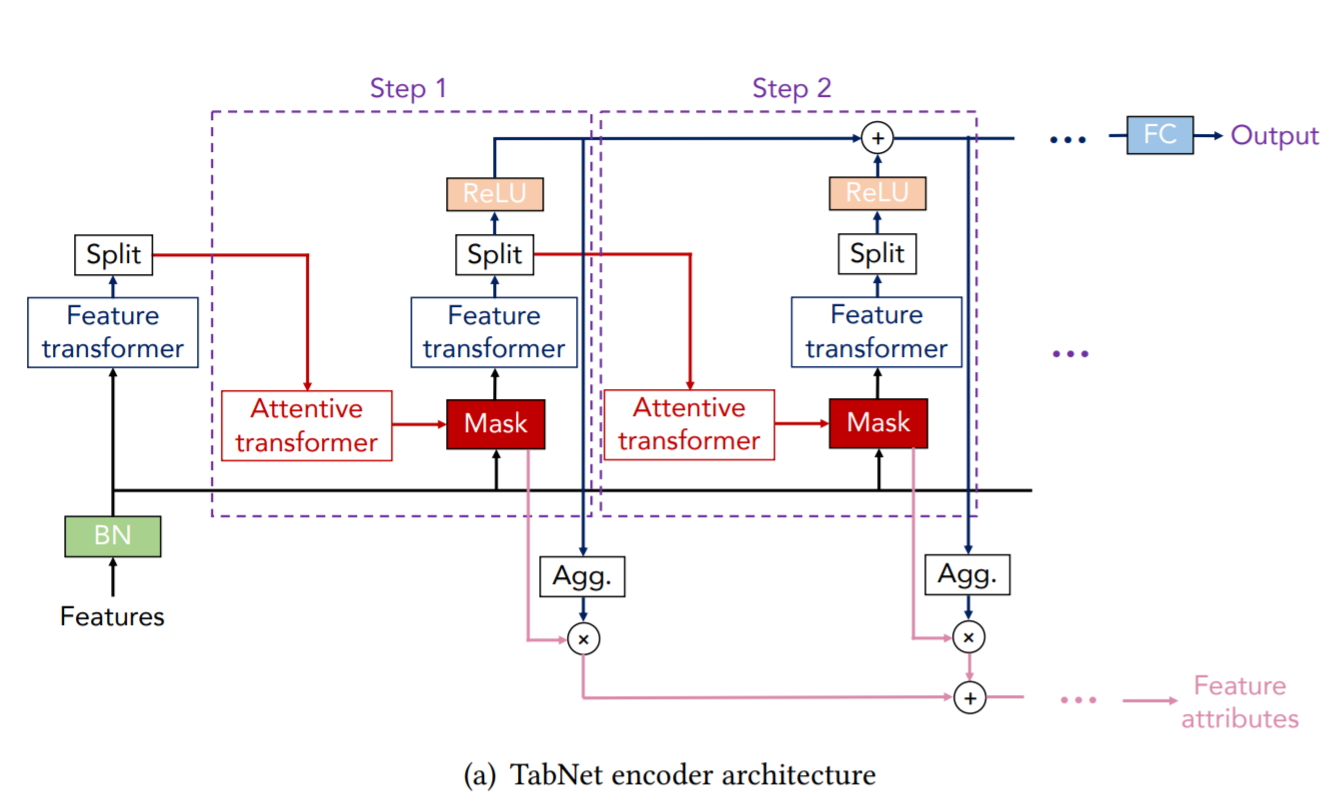

Let's understand the architecture by dissecting the above image in a high-level before diving into the components: 

* You input the features into $N$ steps that are the parallel to tree depth in RF (as seen above).
* At each step, there is a masking mechanism that softly chooses the features to use at that level. 
    * This masking mechanism can then be used for instance feature interpretation (as well as summed to get a global one).
    * The masking function can choose mulitple values to be masked. Furthermore, it's a soft mask, meaning that the values aren't binary (even though the masking function is soft, it tries to keep the mask sparse).
* The masked features are then passed to a "feature transformer".
    * Basically a regular MLP
    * First group of layers are shared accross all steps (encoding of features), rest are step specific. 
* The transformed features of each step are then aggregated and passed through a FC layer. 

# Downloading & Reading our experiment data

In [ ]:
from fastai.tabular.all import * 
import gzip 
import pandas as pd

In [ ]:
data_dir = Path('./data')

In [ ]:
def extract_gzip(file, dest=None):
    dest = dest or Path(dest)
    with gzip.open(file, 'rb') as f_in:
        with open(dest / file.stem, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [ ]:
forest_type_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
forest_path = untar_data(forest_type_url, dest=data_dir, extract_func=extract_gzip)

In [ ]:
adult_path = untar_data(URLs.ADULT_SAMPLE, dest=data_dir)

# Baseline Score

In [ ]:
df = pd.read_csv(forest_path, header=None)
df = df_shrink(df)

In [ ]:
df.head()

In [ ]:
df.memory_usage().sum() / 1e6

In [ ]:
df.shape

In [ ]:
for c in df.columns: 
    print(c, df[c].nunique(), df[c].agg(['min', 'max']).to_list())

In [ ]:
df[7].value_counts().head(20)

In [ ]:
dls = TabularDataLoaders.from_df(df, path=data_dir, y_names=54, y_block=CategoryBlock,
    cat_names = [],
    cont_names = df.columns.difference([54]).to_list(),
    procs = [Categorify, FillMissing, Normalize])

In [ ]:
dls.valid.xs

In [ ]:
learn = tabular_learner(dls, metrics=[accuracy])

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 1e-2)

Ok. So when treating everything as a cont variable, we get ~86% accuracy. What about when we treat it as a cat variable? 

In [ ]:
dls = TabularDataLoaders.from_df(df, path=data_dir, y_names=54, y_block=CategoryBlock,
    cat_names =  df.columns.difference([54]).to_list(),
    cont_names = [],
    procs = [Categorify, FillMissing, Normalize])

In [ ]:
learn = tabular_learner(dls, metrics=[accuracy])

In [ ]:
learn.fine_tune(10, 1e-2)